In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import pyPyrTools as ppt
import math
from scipy import stats
from scipy import optimize as opt
import torch

/home/wfb229/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
../sfp/plotting.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, i

../sfp/design_matrices.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/wfb229/.conda/envs/sfp/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/wfb229/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().s

To explain the motivation behind this model, let's step through some reasoning.

In [2]:
# Some setup for torch, loading in data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')

df_path = "/scratch/wfb229/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv"
# df_path = "/home/billbrod/Data/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv"
df = pd.read_csv(df_path)

In [3]:
# This is necessary for now, so we normalize values across voxels, but eventually we'll take care of this during the first level analysis
gb = df.groupby(['varea', 'voxel'])
df = df.set_index(['varea', 'voxel'])
df['amplitude_estimate_norm'] = gb.amplitude_estimate_median.apply(np.linalg.norm, 2)
df = df.reset_index()
df['amplitude_estimate_median_normed'] = df.amplitude_estimate_median / df.amplitude_estimate_norm

Let's look at some voxels that have good GLM $R^2$ values and pick one

In [4]:
df[(df.varea==1)&(df.R2>55)].drop_duplicates('voxel').sort_values('R2', ascending=False).head(20)[['voxel', 'R2', 'varea', 'hemi', 'angle' ,'eccen', 'precision']]

,voxel,R2,varea,hemi,angle,eccen,precision
1421,1421,65.773674,1,lh,0.848843,8.170883,0.721447
53,53,65.208328,1,lh,1.522200,5.022409,2.696543
1422,1422,65.189392,1,lh,0.782562,8.108796,0.716224
50,50,65.087975,1,lh,1.544481,4.639922,2.686019
1305,1305,64.600609,1,lh,0.883381,8.023201,0.824230
1423,1423,64.564117,1,lh,0.759333,8.078571,0.696492
1306,1306,63.813404,1,lh,0.791223,7.958213,0.707783
1418,1418,63.339008,1,lh,0.721658,8.177013,0.679700
359,359,62.248016,1,lh,0.782402,4.130862,1.542490
1177,1177,62.232727,1,lh,0.842448,7.687730,0.681345


In [5]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel.isin([264]))]#, 1421]))]
voxel_df.head()

,varea,voxel,stimulus_superclass,w_r,w_a,eccen,angle,stimulus_class,amplitude_estimate_std_error,hemi,...,local_sf_ra_direction,local_sf_xy_direction,local_w_a,local_w_r,local_w_x,local_w_y,baseline,precision,amplitude_estimate_norm,amplitude_estimate_median_normed
264,1,264,angular,0.0,6.0,3.87473,0.693137,0,0.808466,lh,...,1.570796,2.263933,0.246451,1.509075e-17,-0.157470,0.189581,0,2.318412,66.852885,0.047084
5942,1,264,angular,0.0,8.0,3.87473,0.693137,1,0.306111,lh,...,1.570796,2.263933,0.328601,2.012100e-17,-0.209961,0.252775,0,2.318412,66.852885,0.070611
11620,1,264,angular,0.0,11.0,3.87473,0.693137,2,0.898055,lh,...,1.570796,2.263933,0.451826,2.766637e-17,-0.288696,0.347565,0,2.318412,66.852885,0.105551
17298,1,264,angular,0.0,16.0,3.87473,0.693137,3,0.875150,lh,...,1.570796,2.263933,0.657202,4.024200e-17,-0.419921,0.505549,0,2.318412,66.852885,0.132337
22976,1,264,angular,0.0,23.0,3.87473,0.693137,4,0.941194,lh,...,1.570796,2.263933,0.944727,-3.616954e-16,-0.603637,0.726727,0,2.318412,66.852885,0.189833


In [6]:
sns.set_context('notebook')
sns.set_style('white')

In [12]:
pal = sns.palettes.color_palette('deep', 5)
pal = {'radial': pal[0], 'reverse spiral': pal[4], 'forward spiral': pal[2], 'angular': pal[3], 'mixtures': pal[1]}
hue_order = ['radial', 'reverse spiral', 'forward spiral', 'angular', 'mixtures']

Let's examine the response of this voxel as a function of spatial frequency. In the plot below, we plot the normed amplitude estimate as a function of the local spatial frequency. We see that the response looks roughly log-Normal, but there appears to be some difference between the different stimulus classes.

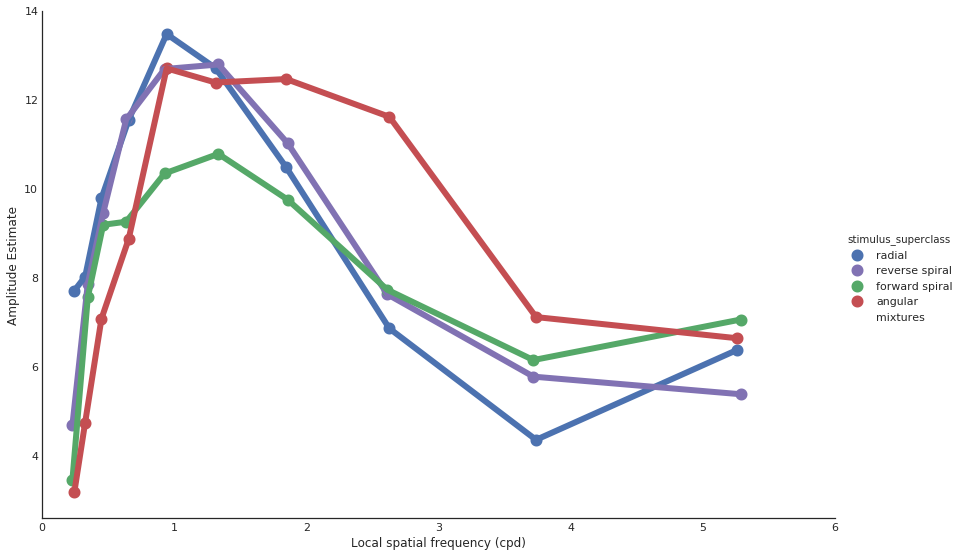

In [13]:
g = sns.FacetGrid(voxel_df[~voxel_df.stimulus_superclass.isin(['mixtures'])], hue='stimulus_superclass',palette=pal, size=8, aspect=1.5, hue_order=hue_order)
g.map(plt.scatter, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
g.map(plt.plot, 'local_sf_magnitude', 'amplitude_estimate_median', linewidth=6)
# g.ax.set_xscale('log', basex=2)
g.add_legend()
g.ax.tick_params(size=0)
g.ax.set_xlim((0, 6))
g.set_xlabels('Local spatial frequency (cpd)')
g.set_ylabels('Amplitude Estimate')

These classes differ in their local orientation, so we can look at a plot of the response as a function of the local spatial frequency with respect to x and y (size represents the response). This plot is difficult to parse, but the main point is that these different stimulus classes are not arbitrary and discrete: they lie on a continuum, related by the stimulus orientation, and so we can fit the response of the voxel as a 2d tuning curve.

/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/wfb229/.local/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


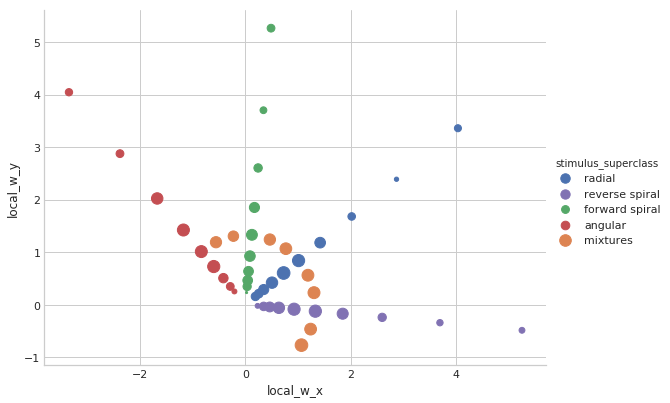

In [14]:
def scatter_sizes(x, y, s, plot_color=False, cmap=None, size_scale=1, **kwargs):
    if plot_color:
        kwargs.pop('color')
        if cmap is None:
            cmap = 'Blues'
        plt.scatter(x, y, s=s*80*size_scale, c=s, cmap=cmap, **kwargs)
    else:
        plt.scatter(x, y, s=s*80*size_scale, **kwargs)

with sns.axes_style('whitegrid'):
    voxel_df['normalized_resp'] = voxel_df['amplitude_estimate_median'].copy()
    voxel_df['normalized_resp'] = (voxel_df['normalized_resp'] - voxel_df['normalized_resp'].min()) / (voxel_df['normalized_resp'].max() - voxel_df['normalized_resp'].min())
    g=sns.FacetGrid(voxel_df, size=8, aspect=1, hue='stimulus_superclass', palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp', plot_color=False, size_scale=2)
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_aspect('equal')
    g.ax.tick_params(size=0)

This is just that same data, but rotated and plotted on a semi-log plots.

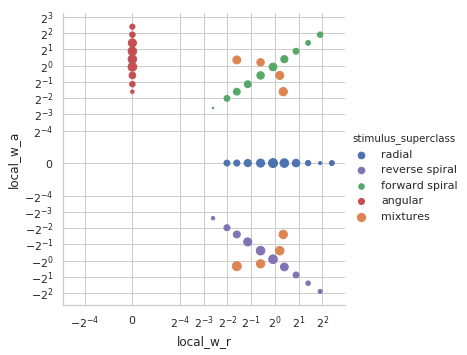

In [10]:
with sns.axes_style('whitegrid'), sns.plotting_context('notebook'):
    g=sns.FacetGrid(voxel_df, hue='stimulus_superclass', size=5, aspect=1, palette=pal, hue_order=hue_order)
    g.map(scatter_sizes, 'local_w_r', 'local_w_a', 'normalized_resp')
    g.add_legend()
    scatter_ax = plt.gca()
    scatter_ax.set_xscale('symlog', basex=2, linthreshx=2**(-4))
    scatter_ax.set_yscale('symlog', basey=2, linthreshy=2**(-4))

But then the question is: how does the tuning change with orientation? Two possibilities are:

1. The preferred frequency of the tuning curve / mode of the log-Gaussian distribution changes with orientation.
2. The amplitude of the tuning curve changes with orientation.

Then there's the question of how either the mode or the amplitude changes with orientation. Let's assume it changes smoothly and periodically, symmetrically about 180 degrees (because 2d orientation is runs from 0 to 180 degrees). We'll examine three possibilities in the plots below, from left to right:

1. all orientation are equally important (mode/amplitude does not depend on orientation; constant)
2. horizontal or vertical is preferred, but the other is anti-preferred (sinusoid with frequency $2\theta$)
3. the cardinals are preferred, the obliques are anti-preferred (sinusoid with frequency $4\theta$)

The following plots show these three possibilities, with the top showing a plot of orientation vs mode/response, while the bottom shows this on an x/y plot: the line represents either the mode or the level set of the max amplitude.

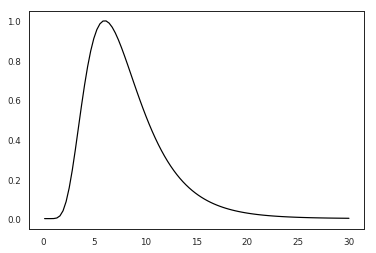

In [11]:
with sns.plotting_context('paper'), sns.axes_style('white'):
    x = np.linspace(.1, 30, 100)
    y = sfp.tuning_curves.log_norm_pdf(x,1, 6, .45)
    plt.plot(x, y, 'k')

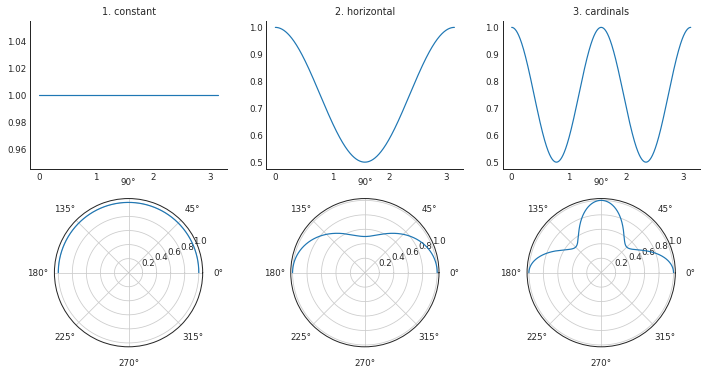

In [12]:
with sns.plotting_context('paper'):
    fig = plt.figure(figsize=(12,6))
    theta = np.linspace(0, np.pi, 1000)
    for i, f, title in zip(range(3), [0, 2, 4], ['1. constant', '2. horizontal', '3. cardinals']):
        r = (np.cos(f*theta) + 3) / 4
        ax = plt.subplot(2,3,i+1)
        ax.plot(theta, r)
        ax.tick_params(size=0)
        sns.despine(ax=ax)
        ax.set_title(title)
        ax = plt.subplot(2,3,4+i, projection='polar')
        ax.plot(theta, r)

Okay so then how do we set up the function that we're going to fit? First, let's look at the 1d log-Normal distribution we used before. Normally, this distribution is parameterized by $\mu$ and $\sigma^2$. These are *not* the mean and variance, the way they are for the regular Normal distribution. We'll keep using $\sigma^2$ but we'll use the mode, $M$ instead of $\mu$: $M = \exp(\mu - \sigma^2) \Rightarrow \mu = \ln(M) + \sigma^2$.

Thus, when we're modeling the response, $R$ as a 1d log-Normal tuning curve with respect to the spatial frequency $\omega$, it's: $R=A * \exp(-\frac{(\ln(\omega)-\ln(M)-\sigma^2)^2}{2\sigma^2})$.

Now we're extending this to make it 2d, as a funtion of spatial frequency $\omega$ and orientation $\theta$. To allow for the amplitude varying with orientation, we expand upon $A$ and make it orientation-dependent: $A_0 + A_1\cos2\theta + A_2\cos4\theta$. To allow the mode to vary, we make similarly make $M$ orientation-dependent: $M_0 + M_1\cos2\theta + M_2\cos4\theta$.

Putting it altogether we get:

$(A_0 + A_1\cos2\theta + A_2\cos4\theta)\exp(-\frac{(\ln(\omega)-\ln(M_0 + M_1\cos2\theta + M_2\cos4\theta)-\sigma^2)^2}{2\sigma^2})$

which gives us 7 parameters to fit: $A_0, A_1, A_2, M_0, M_1, M_2, \sigma$

Let's look at some examples of this function, to get a sense of its expressive power.

In [25]:
omega = np.logspace(-3, 3, 100, base=2)
theta = np.linspace(0, 2*np.pi, 100)

def log_norm_2d(omega, theta, A0=1, A1=0, A2=0, M0=1, M1=0, M2=0, sigma=1):
    omega = np.array(omega)
    theta = np.array(theta)
    amp = A0 + A1*np.cos(2*theta) + A2*np.cos(4*theta)
    mode = M0 + M1*np.cos(2*theta) + M2*np.cos(4*theta)
    #pdf = (1/(omega*sigma*np.sqrt(2*np.pi))) * np.exp(-(np.log(omega)-mu)**2/(2*sigma**2))
    #pdf /= pdf.max()
    pdf = sfp.tuning_curves.log_norm_pdf(omega, amp, mode, sigma)
    return pdf

omega, theta = np.meshgrid(omega, theta)

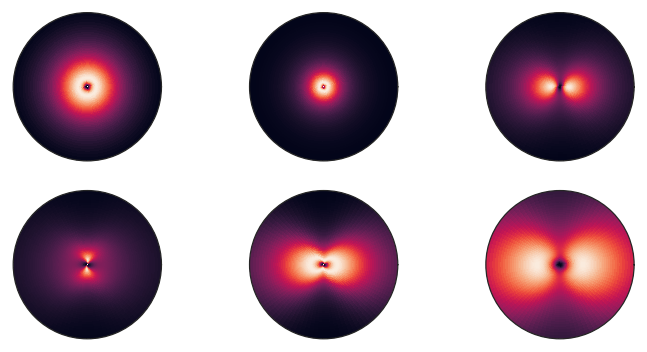

In [26]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

params = [{}, {'M0': .5}, {'A1': .5}, {'M1': .5}, {'A1': .5, 'M1': .5, 'M0': 1}, {'A1': .5, 'M1': .5, 'M0':2}]

with sns.plotting_context('notebook'):
    for i, ax in enumerate(axes.flatten()):
        R = log_norm_2d(omega, theta, **params[i])
        ax.pcolormesh(theta, omega, R)
        ax.set_xticks([])
        ax.set_rticks([])

This is on a voxel-by-voxel basis, but what about across the whole area? To extend it to all of V1, let's consider two frames of reference: fixed and relative.

In the fixed frame, all voxels have the same tuning. Orientation, $\theta_f$, above refers to Cartesian, world-relate orientation so that $\theta_f=0$ corresponds to "to the right". Spatial frequency, $\omega_f$, means the local spatial frequency in the image. This encodes our "constant" extreme possibility from earlier.

In the relative frame, voxel tuning depends on its location in the retinotopic map. We remap orientation and spatial frequency so that $\theta_r=0$ corresponds to "away from the fovea" and spatial frequency is scaled by eccentricity: $\omega_r=\omega_f(e+b)$, where $e$ is the eccentricity of the voxel's pRF and $b$ is some constant.

We then sum these two versions of the model so that we have a 15-parameter model (two versions of the 7 parameters above, plus $b$) that we fit simultaneously to all of V1.

# Torch

In [7]:
import warnings
def torch_meshgrid(x, y=None):
    """from https://github.com/pytorch/pytorch/issues/7580"""
    if y is None:
        y = x
    x = torch.tensor(x, dtype=torch.float64)
    y = torch.tensor(y, dtype=torch.float64)
    m, n = x.size(0), y.size(0)
    grid_x = x[None].expand(n, m)
    grid_y = y[:, None].expand(n, m)
    return grid_x, grid_y

def _cast_as_param(x):
    return torch.nn.Parameter(torch.tensor(x, dtype=torch.float64))

class LogGaussianDonut(torch.nn.Module):
    """simple LogGaussianDonut in pytorch
    """
    def __init__(self, amplitude, mode, sigma, sf_ecc_slope=1, sf_ecc_intercept=0):
        super(LogGaussianDonut,self).__init__()
        self.amplitude = _cast_as_param(amplitude)
        self.mode = _cast_as_param(mode)
        self.sigma = _cast_as_param(sigma)
        self.sf_ecc_slope = _cast_as_param(sf_ecc_slope)
        self.sf_ecc_intercept = _cast_as_param(sf_ecc_intercept)
        
    def _create_mag_angle(self, extent=(-10, 10), n_samps=1001):
        x = torch.linspace(extent[0], extent[1], n_samps)
        x, y = torch_meshgrid(x)
        r = torch.sqrt(torch.pow(x, 2) + torch.pow(y, 2))
        th = torch.atan2(y, x)
        return r, th
    
    def create_image(self, vox_ecc, vox_angle, extent=None, n_samps=1001):
        r, th = self._create_mag_angle(extent, n_samps)
        return self.evaluate(r, th, vox_ecc, vox_angle)
    
    def log_norm_pdf_1d(self, x):
        """the pdf of a one-dimensional log normal distribution, with a scale factor

        we parameterize this using the mode instead of mu because we place constraints on the mode
        during optimization
        """
        mu = torch.log(self.mode) + torch.pow(self.sigma, 2)
        pdf = (1/(x*self.sigma*np.sqrt(2*np.pi))) * torch.exp(-(torch.log(x)-mu)**2/(2*torch.pow(self.sigma, 2)))
        # pdf = pdf / pdf.max()
        return self.amplitude * pdf

    def evaluate(self, sf_mag, sf_angle, vox_ecc, vox_angle):
        variables = {'sf_mag': sf_mag, 'sf_angle': sf_angle, 'vox_ecc': vox_ecc, 'vox_angle': vox_angle}
        for k, v in variables.iteritems():
            if not torch.is_tensor(v):
                v = torch.tensor(v, dtype=torch.float64)
            if self.amplitude.is_cuda:
                v = v.cuda()
            variables[k] = v
        relative_freq = variables['sf_mag'] * (self.sf_ecc_slope * variables['vox_ecc'] + self.sf_ecc_intercept)
        relative_freq = torch.clamp(relative_freq, min=1e-12)
        return self.log_norm_pdf_1d(relative_freq)

    def forward(self, spatial_frequency_magnitude, spatial_frequency_theta, voxel_eccentricity, voxel_angle):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.evaluate(spatial_frequency_magnitude, spatial_frequency_theta, voxel_eccentricity, voxel_angle)

    
class ConstantLogGaussianDonut(LogGaussianDonut):
    """this version does not depend on voxel eccentricity or angle at all, mainly for demo purposes"""
    def __init__(self, amplitude, mode, sigma):
        # this way the "relative frequency" is sf_mag * (0*voxel_ecc + 1) = sf_mag
        super(ConstantLogGaussianDonut, self).__init__(amplitude, mode, sigma, 0, 1)
        
    def create_image(self, extent=None, n_samps=1001):
        r, th = self._create_mag_angle(extent, n_samps)
        return self.evaluate(r, th)
        
    def evaluate(self, sf_mag, sf_angle):
        return super(ConstantLogGaussianDonut, self).evaluate(sf_mag, sf_angle, 0, 0)
        
    def forward(self, spatial_frequency_magnitude, spatial_frequency_theta):
        return self.evaluate(spatial_frequency_magnitude, spatial_frequency_theta)

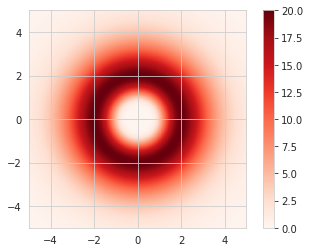

In [5]:
donut = ConstantLogGaussianDonut(20, 2, .4,).to(device)
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image((x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

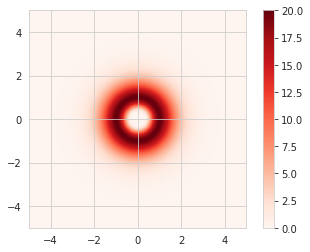

In [6]:
donut = LogGaussianDonut(20, 2, .4,).to(device)
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image(2, np.pi, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

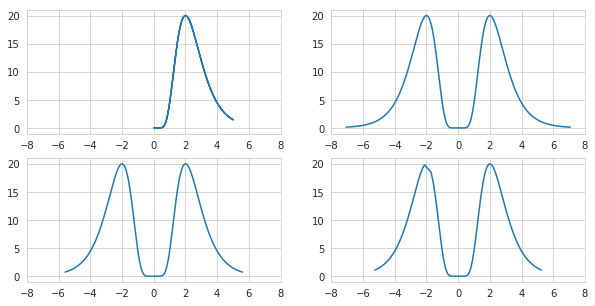

In [7]:
img = donut.create_image(1, 0, (x.min(), x.max()), len(x)).cpu().detach().numpy()
fig, axes = plt.subplots(2,2,figsize=(10, 5))
axes=axes.flatten()
R = ppt.mkR(len(x))
R *= (np.sqrt(2*x.max()**2)/R.max())
R[xgrid<0] *= -1
for ax, a in zip(axes.flatten(), [0, 1, 2, 3]):
    idx = np.where(xgrid==a*ygrid)
    r = R[idx]
    ax.plot(r, img[idx])
    ax.set(xlim=(-8, 8))

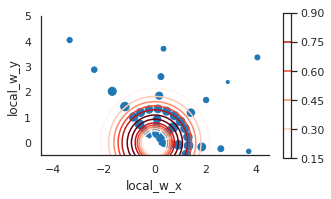

In [28]:
g=sns.FacetGrid(voxel_df, size=5, aspect=1)
g.map(scatter_sizes, 'local_w_x', 'local_w_y', 'normalized_resp')
scatter_ax = plt.gca()
scatter_ax.set_aspect('equal')

mag = torch.tensor(voxel_df.local_sf_magnitude.values, dtype=torch.float64).to(device)
direc = torch.tensor(voxel_df.local_sf_xy_direction.values, dtype=torch.float64).to(device)
ecc = torch.tensor(voxel_df.eccen.values, dtype=torch.float64).to(device)
ang = torch.tensor(voxel_df.angle.values, dtype=torch.float64).to(device)
y = torch.tensor(voxel_df.amplitude_estimate_median.values, dtype=torch.float64).to(device)

donut = LogGaussianDonut(1, 1, .4, 0, 1)
donut.to(device)
x = np.linspace(-3, 3, 101)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
c = scatter_ax.contour(x, x, donut.create_image(ecc[0], ang[0], (x.min(), x.max()), len(x)).detach(), cmap="Reds")
g.fig.colorbar(c, shrink=.5)
scatter_ax.set(xlim=(-4.5, 4.5), ylim=(-.5,5))
scatter_ax.set_aspect('equal')


loss_fn = torch.nn.MSELoss(False)
# AMSGrad argument here means we use a revised version that handles a bug people found where
# it doesn't necessarily converge
optimizer = torch.optim.Adam(donut.parameters(), lr=1e-3, amsgrad=True)

Batch size is a hyper parameter to play around with, not a good rule of thumb for how to pick, except that it should be vary inversely with learning rate (less important with Adam, since it dynamically updates it, but still). Batch shouldn't just be as large as possible, computationally, because there are some results showing it acts as a regularizer (computing the gradient with the full dataset is hard).

Should calculate loss over whole epoch and keep going until loss changes by less than some threshold for 3 or 4 epochs in a row. Every so many epochs, spit out results to keep track of progress.

https://pytorch.org/docs/0.4.0/nn.html#dataparallel-layers-multi-gpu-distributed

https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html

Use DataParallel to split across multiple GPUs and speed up a given batch (so batch needs to be large enough for this to work)

In [25]:
list(donut.named_parameters())

[('amplitude', Parameter containing:
  tensor(1., dtype=torch.float64, device='cuda:0')),
 ('mode', Parameter containing:
  tensor(1., dtype=torch.float64, device='cuda:0')),
 ('sigma', Parameter containing:
  tensor(0.4000, dtype=torch.float64, device='cuda:0')),
 ('sf_ecc_slope', Parameter containing:
  tensor(0., dtype=torch.float64, device='cuda:0')),
 ('sf_ecc_intercept', Parameter containing:
  tensor(1., dtype=torch.float64, device='cuda:0'))]

In [92]:
from torch.utils import data as torchdata
class FirstLevelDataset(torchdata.Dataset):
    def __init__(self, df_path, direction_type='relative'):
        self.df = pd.read_csv(df_path)
        if direction_type not in ['relative', 'absolute']:
            raise Exception("Don't know how to handle direction_type %s!" % direction_type)
        self.direction_type = direction_type
        
    def __getitem__(self, idx):
        row = df.iloc[idx]
        if self.direction_type == 'relative':
            vals = row[['local_sf_magnitude', 'local_sf_ra_direction', 'eccen', 'angle']].values
        elif self.direction_type == 'absolute':
            vals = row[['local_sf_magnitude', 'local_sf_xy_direction', 'eccen', 'angle']].values
        feature = torch.tensor(vals.astype(float), dtype=torch.float64)
        try:
            target = torch.tensor(row['amplitude_estimate_normed'], dtype=torch.float64)
        except KeyError:
            target = torch.tensor(row['amplitude_estimate_median_normed'], dtype=torch.float64)
        return feature, target
    
    def get_voxel(self, idx):
        vox_idx = df[df.voxel==idx].index
        return self[vox_idx]
            
    def __len__(self):
        return self.df.shape[0]

In [29]:
ds = FirstLevelDataset(df_path)
dl = torchdata.DataLoader(ds, 2000,)# shuffle=True)
loss_prev = 0.01
n_epochs = 5
thresh = .00001
loss_history = []
for j, t in enumerate(range(n_epochs)):
    loss_history.append([])
    for i, (features, target) in enumerate(dl):
        predictions = donut(*features.transpose(1, 0))
        loss = loss_fn(predictions, target.to(device))
        if i % 10 == 0:
            print(i, loss.item())
        if np.isnan(loss.item()):
            print(i)
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if abs((loss - loss_prev) / loss_prev) < thresh:
            break
        loss_prev = loss
        loss_history[j].append(loss.item())
print("Final loss: %02f" % loss)

(0, 69.13811799949714)
(10, 187.519955418336)
(20, 346.3477709160243)
(30, 34.72093215156752)
(40, 135.23129295248393)
(50, 361.3140512751548)
(60, 52.315678772393994)
(70, 124.2559481426888)
(80, 272.6130452965418)
(90, 46.321207801463025)
(100, 84.26311739721622)
(110, 181.32959888461951)
(120, 68.22773670815708)
(130, 88.7550293717581)
(0, 21.553610425588044)
(10, 70.55289025623662)
(20, 120.86844185140981)
(30, 23.19473013167454)
(40, 55.56618635939467)
(50, 149.50095125441194)
(60, 35.52980237364265)
(70, 58.14923969502847)
(80, 135.2696996102362)
(90, 29.455544203901997)
(100, 36.815489897934214)
(110, 95.27671609392841)
(120, 34.244230968806264)
(130, 41.07234257680277)
(0, 13.277174883265962)
(10, 43.7215775154571)
(20, 60.43639097948743)
(30, 19.80789216365696)
(40, 31.30289630218868)
(50, 84.13063777129562)
(60, 30.262678010010664)
(70, 36.00797709954434)
(80, 75.51145063468739)
(90, 23.379498125029006)
(100, 20.821533507542583)
(110, 56.424795684709196)
(120, 21.842979213668

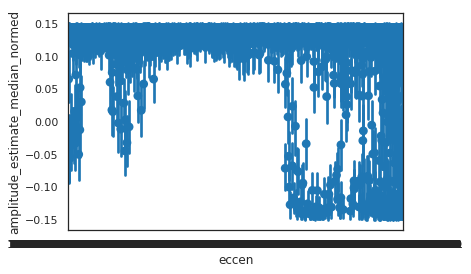

In [170]:
sns.pointplot('eccen', 'amplitude_estimate_median_normed', data=df, join=False)

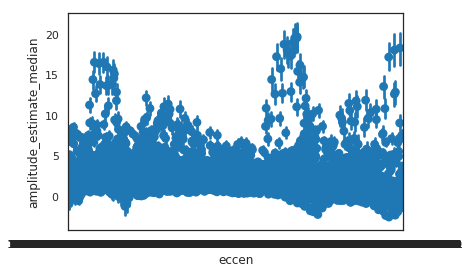

In [169]:
sns.pointplot('eccen', 'amplitude_estimate_median', data=df, join=False)

In [153]:
donut.eval()

LogGaussianDonut()

In [32]:
loss_history = np.array(loss_history)
loss_df = pd.DataFrame(loss_history)
loss_df = pd.melt(loss_df.reset_index(), id_vars='index',var_name='batch_num', value_name='loss', ).rename(columns={'index': 'epoch_num'})

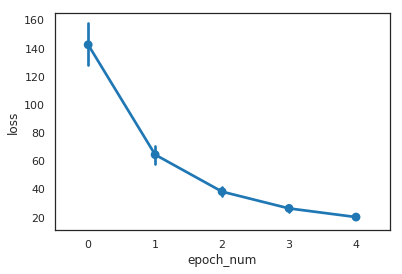

In [67]:
sns.pointplot('epoch_num', 'loss', data=loss_df, )

In [151]:
list(donut.named_parameters())

[('amplitude', Parameter containing:
  tensor(0.6975, dtype=torch.float64, device='cuda:0')),
 ('mode', Parameter containing:
  tensor(1.2160, dtype=torch.float64, device='cuda:0')),
 ('sigma', Parameter containing:
  tensor(0.6736, dtype=torch.float64, device='cuda:0')),
 ('sf_ecc_slope', Parameter containing:
  tensor(1.00000e-04 *
         -9.4285, dtype=torch.float64, device='cuda:0')),
 ('sf_ecc_intercept', Parameter containing:
  tensor(1.0070, dtype=torch.float64, device='cuda:0'))]

In [144]:
donut.
corrs = []
for i in df.voxel.unique():
    actuals = ds.get_voxel(i)[1]
    preds = donut(*ds.get_voxel(i)[0].transpose(0, 1))
    corr = np.corrcoef(actuals.cpu().detach().numpy(), preds.cpu().detach().numpy())
    corrs.append([i, corr[0,1], loss_fn(preds, actuals.to(device)).item()])

corrs = pd.DataFrame(corrs, columns=['voxel', 'correlation', 'loss'])
df = df.set_index('voxel')
corrs = corrs.set_index('voxel')
corrs = corrs.join(df[['eccen']], 'voxel',).drop_duplicates().reset_index()
df = df.reset_index()

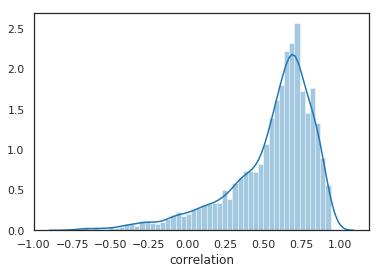

In [147]:
sns.distplot(corrs['correlation'])

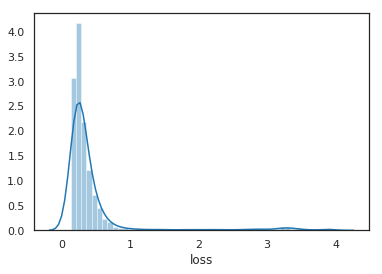

In [148]:
sns.distplot(corrs['loss'])

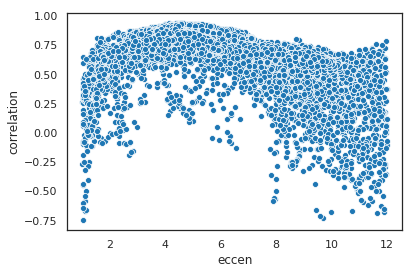

In [165]:
sns.scatterplot('eccen', 'correlation', data=corrs)

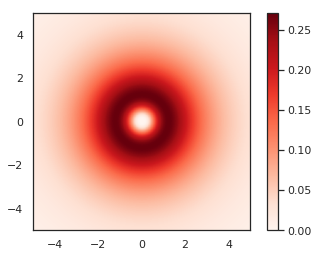

In [159]:
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image(10, np.pi, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

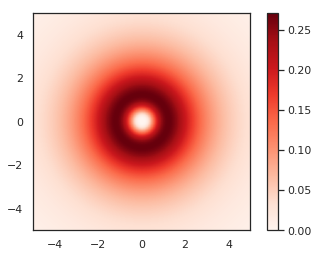

In [55]:
x = np.linspace(-5, 5, 1001)
xgrid, ygrid = np.meshgrid(x, x)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image(.01, np.pi, (x.min(), x.max())).detach(), extent=(x.min(),x.max(), x.min(), x.max()), cmap='Reds')
plt.colorbar()

NameError: name 'y_pred' is not defined

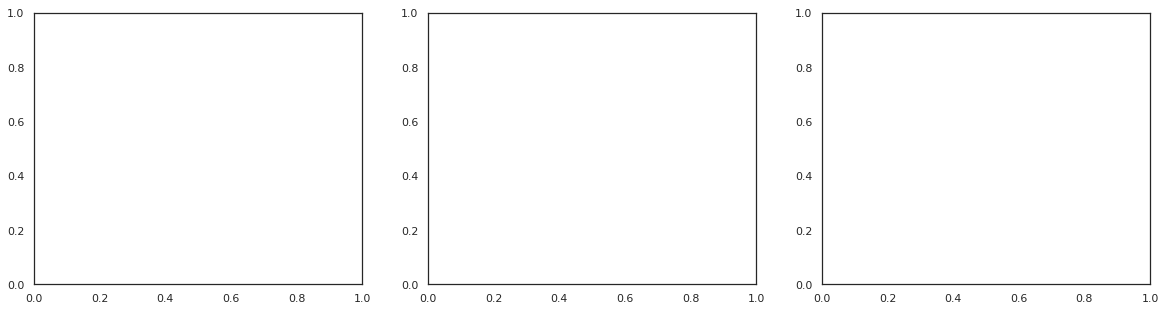

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
vals = [y.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), y.cpu().detach().numpy() - y_pred.cpu().detach().numpy()]
titles = ['ground truth', 'predicted', 'ground truth - predicted']
for ax, v, t in zip(axes.flatten(), vals, titles):
    scaled_v = (v - abs(v).min()) / (abs(v).max() - abs(v).min())
    pts=ax.scatter(voxel_df['local_w_x'], voxel_df['local_w_y'], s=abs(scaled_v)*50, c=v, cmap='RdBu_r', norm=sfp.plotting.MidpointNormalize(midpoint=0))
    ax.set_aspect('equal')
    plt.colorbar(pts, ax=ax, shrink=.6)
    ax.set(xlim=(-4.5, 4.5), ylim=(-.5, 5))
    ax.set_title(t)

In [99]:
x = np.linspace(-8, 8, 1001)
# detach() is required to separate it from the graph implied by setting `requires_grad=True` above
plt.imshow(donut.create_image((x.min(), x.max())).cpu().detach(), extent=(x.min(),x.max(), x.min(), x.max()),cmap='RdBu_r', norm=sfp.plotting.MidpointNormalize(midpoint=0))
ax = plt.gca()
ax.set(xlim=(-4.5, 4.5), ylim=(-.5, 5))
plt.colorbar(shrink=.7)

TypeError: create_image() takes at least 3 arguments (2 given)